In [1]:
# lembrar de instalar, pois precisa do driver de banco de dados: pip install mysql-connector
import mysql.connector
from sqlalchemy import create_engine
from sqlalchemy import Engine
from matplotlib import pyplot as plt
# caso de erro de backend do matplotlib, instalar: pip install matplotlib-inline
import pandas as pd
import numpy as np
import seaborn as sns

In [33]:
# Querying data from database

SQL_ALL_USERS: str = "SELECT * FROM usuario"


SQL_MEAN_CONVERT_PROCESS_STATUS: str = """
    SELECT status_processo, 
	    COUNT(status_processo) AS total_por_status,
	    (COUNT(status_processo) * 100.0 / (SELECT COUNT(*) FROM status_processo_seletivo)) AS porcentagem
    FROM status_processo_seletivo
    GROUP BY status_processo;
"""


SQL_QUANTITY_CANDIDATES_BY_STAGE_AND_POSITION: str = """
    SELECT 
        c.nome_cargo,
        e.nome_etapa,
        COUNT(v.id_cargo) AS candidatos_cargo_etapa
    FROM status_processo_seletivo sps
    INNER JOIN etapa e ON sps.id_etapa = e.id_etapa
    INNER JOIN vaga v ON sps.id_vaga = v.id_vaga
    INNER JOIN cargo c ON v.id_cargo = c.id_cargo
    GROUP BY e.nome_etapa, c.nome_cargo;
"""


SQL_MEAN_PER_SALARY_OF_POSITION: str = """
    SELECT 
	    c.nome_cargo,
	    AVG(v.salario) AS media_salario
    FROM vaga v
    INNER JOIN cargo c ON v.id_cargo = c.id_cargo
    GROUP BY c.nome_cargo;
"""


SQL_MEAN_DAYS_PROCESSING: str = """
    SELECT AVG(LEAST(DATEDIFF(
        COALESCE(DATE(sps.data_conclusao), DATE(i.data_inscricao)), 
        DATE(i.data_inscricao)), 14)) AS diferenca_dias
    FROM inscricao i
    INNER JOIN status_processo_seletivo sps ON i.id_inscricao = sps.id_status_processo_seletivo;
"""


SQL_MEDIA_TEMPO_POR_VAGA: str = """
    SELECT v.nome_vaga,
	    AVG(LEAST(DATEDIFF(
           COALESCE(DATE(sps.data_conclusao), DATE(i.data_inscricao)), 
           DATE(i.data_inscricao)), 14)) AS diferenca_dias
    FROM inscricao i
    INNER JOIN status_processo_seletivo sps ON i.id_inscricao = sps.id_status_processo_seletivo
    INNER JOIN vaga v ON v.id_vaga = sps.id_vaga
    GROUP BY v.nome_vaga;
"""


SQL_DISTRIBUICAO_CANDIDATOS_POR_CARGO: str = """
    SELECT c.nome_cargo, COUNT(i.id_inscricao) AS quantida_por_cargo
    FROM inscricao i
    INNER JOIN vaga v ON v.id_vaga = i.id_vaga
    INNER JOIN cargo c ON c.id_cargo = v.id_cargo
    GROUP BY c.nome_cargo;
"""

In [3]:
# Configs do Banco de Dados Local de testes para Analise de Dados 

DATABASE_TYPE: str = "mysql"
DBAPI: str = "mysqlconnector"
USER: str = "root"
PASSWORD: str = ""
HOST: str = "localhost"
PORT: str = "3306"
DATABASE: str = "controle_processo_seletivo"

In [4]:
def connection_database() -> Engine:
    try:
        connection_string: str = f"{DATABASE_TYPE}+{DBAPI}://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}"
        engine: Engine = create_engine(connection_string)
        
        with engine.connect() as connection:
            print("Conexão bem-sucedida!")
    except Exception as e:
        raise print(e)
    
    return engine

In [5]:
# Média de conversão por status do processo seletivo
def mean_convert_process_status() -> pd.DataFrame:
    df: pd.DataFrame = pd.read_sql(SQL_MEAN_CONVERT_PROCESS_STATUS, connection_database())
    return df

df_mean_convert: pd.DataFrame = mean_convert_process_status()
df_mean_convert

Conexão bem-sucedida!


,status_processo,total_por_status,porcentagem
0,CONCLUÍDO,24,5.13919
1,REPROVAÇÃO,239,51.17773
2,DESISTÊNCIA,190,40.68522
3,ENCERRADO,9,1.92719
4,BANCO DE TALENTOS,2,0.42827
5,ATIVO,3,0.64240


# Média de Conversão de Candidatos por Status no processo seletivo

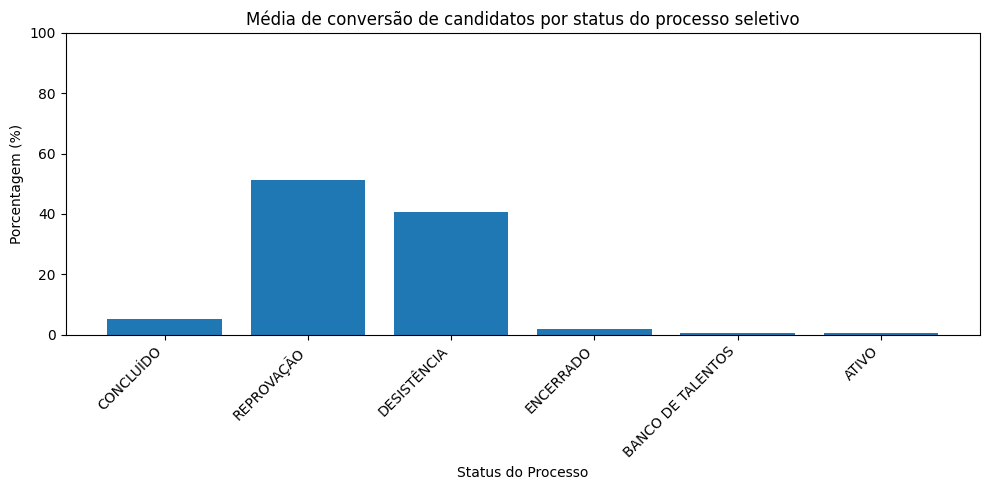

In [6]:
coluna_status_processo: list[str] = df_mean_convert["status_processo"].tolist()
coluna_porcentagem: list[float] = df_mean_convert["porcentagem"].tolist()

plt.figure(figsize=(10, 5))
plt.bar(coluna_status_processo, coluna_porcentagem)

plt.title("Média de conversão de candidatos por status do processo seletivo")
plt.xlabel("Status do Processo")
plt.ylabel("Porcentagem (%)")

plt.ylim(0, 100)

plt.xticks(rotation=45, ha="right")

plt.tight_layout()

plt.show()

In [5]:
def quantity_candidates_by_stage_and_position() -> pd.DataFrame:
    df: pd.DataFrame = pd.read_sql(SQL_QUANTITY_CANDIDATES_BY_STAGE_AND_POSITION, connection_database())
    return df

df_quantity_candidates: pd.DataFrame = quantity_candidates_by_stage_and_position()
df_quantity_candidates

Conexão bem-sucedida!


,nome_cargo,nome_etapa,candidatos_cargo_etapa
0,ASSISTENTE DE VENDAS,PRATICA NO SETOR,4
1,ASSISTENTE DE VENDAS,ENTREVISTA COM O RH,34
2,ASSISTENTE DE VENDAS,ENTREVISTA COM O GESTOR,12
3,ASSISTENTE DE VENDAS,FORMS INICIAL,2
4,AGENTE DE REGISTRO,ENTREVISTA COM O RH,60
5,AGENTE DE REGISTRO,FORMS INICIAL,10
6,ESTÁGIO COMERCIAL,FORMS INICIAL,4
7,ESTÁGIO COMERCIAL,ENTREVISTA COM O RH,29
8,ESTÁGIO COMERCIAL,AGENDAR PROXIMA ETAPA,3
9,ESTÁGIO LICITAÇÃO,ENTREVISTA COM O GESTOR,2


In [6]:
# convertendo set para lista com dados vindos do dataframe
lista_de_cargos: list[str] = sorted(set(df_quantity_candidates["nome_cargo"]))
lista_de_etapas: list[str] = sorted(set(df_quantity_candidates["nome_etapa"]))

In [7]:
dicit_aux: dict[str, list[int]] = {}

for i, cargo in enumerate(df_quantity_candidates["nome_cargo"].to_list()):
    if cargo not in dicit_aux:
        dicit_aux[cargo] = []
    dicit_aux[cargo].append(int(df_quantity_candidates.loc[i, "candidatos_cargo_etapa"]))
    
print(dicit_aux)

{'ASSISTENTE DE VENDAS': [4, 34, 12, 2, 3, 4, 1, 1], 'AGENTE DE REGISTRO': [60, 10, 4, 4, 13, 4, 3, 4], 'ESTÁGIO COMERCIAL': [4, 29, 3, 4, 4, 1], 'ESTÁGIO LICITAÇÃO': [2, 12, 4], 'AUXILIAR ADMINISTRATIVO': [7, 90, 32, 5, 1, 8, 7, 7], 'VENDEDOR': [18, 3, 4, 5, 13, 1], 'ASSISTENTE DE FINANCEIRO': [2, 1, 2], 'ESTÁGIO ADM': [1, 16, 1, 12, 2, 2, 1]}


In [11]:
# completando as etapas que não existem para cada cargo

dicit_aux_completo = {}

for cargo in lista_de_cargos:
    etapas_do_cargo = dicit_aux.get(cargo, [])
    etapas_completas = etapas_do_cargo + [0] * (len(lista_de_etapas) - len(etapas_do_cargo))
    dicit_aux_completo[cargo] = etapas_completas
    
print(dicit_aux)

{'ASSISTENTE DE VENDAS': [4, 34, 12, 2, 3, 4, 1, 1], 'AGENTE DE REGISTRO': [60, 10, 4, 4, 13, 4, 3, 4], 'ESTÁGIO COMERCIAL': [4, 29, 3, 4, 4, 1], 'ESTÁGIO LICITAÇÃO': [2, 12, 4], 'AUXILIAR ADMINISTRATIVO': [7, 90, 32, 5, 1, 8, 7, 7], 'VENDEDOR': [18, 3, 4, 5, 13, 1], 'ASSISTENTE DE FINANCEIRO': [2, 1, 2], 'ESTÁGIO ADM': [1, 16, 1, 12, 2, 2, 1]}


# Conversão de Usuários por Cargo e Etapa nos Processos Seletivos

# N entendi o que aconteceu o gráfico tava certo ontem e bugou agora, porém tenho o correto

In [ ]:
# valores para cada etapa em cada cargo
valores = np.array([dicit_aux_completo[cargo] for cargo in lista_de_cargos])
    
# configuração do gráfico de barras agrupadas
largura_barra = 0.1
x = np.arange(len(lista_de_cargos))  # Posições no eixo X

fig, ax = plt.subplots(figsize=(25, 5))

for i in range(len(lista_de_etapas)):
    ax.bar(x + i * largura_barra, valores[:, i], width=largura_barra, label=lista_de_etapas[i])

ax.set_xticks(x + largura_barra * (len(lista_de_etapas) - 1) / 2)
ax.set_xticklabels(lista_de_cargos)
ax.set_ylabel('Total por Cargo')
ax.set_title('Distribuição de Candidatos por Cargo e Etapa')
ax.legend(title='Etapas')

plt.ylim(0, 100)

plt.xticks(rotation=45, ha="right")

plt.show()


Da pra se notar aqui que geralmente os setores que tem maior quantidade de entrevistas são os mesmo que geralmente tem maior rotatividade de pessoas, visto que a maioria dos candidatos param na etapa de *Entrevista com RH*, que normalmente é uma das etapas inicias

# Porque poucas contratações e uma base muito grande Reprovação-Desistência e até mesmo baixa base de Contratados?

In [13]:
def mean_per_salary_of_position() -> pd.DataFrame:
    df: pd.DataFrame = pd.read_sql(SQL_MEAN_PER_SALARY_OF_POSITION, connection_database())
    return df

df_mean_per_salary: pd.DataFrame = mean_per_salary_of_position()
df_mean_per_salary

Conexão bem-sucedida!


,nome_cargo,media_salario
0,ASSISTENTE DE VENDAS,1600.0
1,AGENTE DE REGISTRO,1700.0
2,ESTÁGIO COMERCIAL,700.0
3,ESTÁGIO LICITAÇÃO,700.0
4,AUXILIAR ADMINISTRATIVO,1550.0
5,VENDEDOR,1500.0
6,ASSISTENTE DE FINANCEIRO,1500.0
7,ESTÁGIO ADM,800.0


### Agente de registro - R$1.800 - VeG Certificação Digital Unidade

### Estagiário comercial - R$918,00 - RHESERVA

### Estagiário Licitações - R$1.000,00 - GRUPO SUPORTE

### Auxiliar administrativo - R$1.800,00 - INCLUSAO CONSULTORIA

### Assistente de vendas - R$2.000,00 - EMBRASUL-INDUSTRIA ELETRONICA LTDA

### Vendedor comercial - R$2.278,00 em média - DCN SOLUCOES EM RH

### Assistente financeiro - R$1.926,00 em média - Iesde Brasil

### Estágio administrativo - R$1.500,00 - FAZ CAPITAL

In [14]:
cargo_diferenca_salario: dict[str, list[float]] = {}
salarios_cargos_outras_empresas = [
    ("ASSISTENTE DE VENDAS", 2000),
    ("AGENTE DE REGISTRO", 1800),
    ("ESTÁGIO COMERCIAL", 918),
    ("ESTÁGIO LICITAÇÃO", 1000),
    ("AUXILIAR ADMINISTRATIVO", 1800),
    ("VENDEDOR", 2278),
    ("ASSISTENTE FINANCEIRO", 1926),
    ("ESTÁGIO ADM", 1500)
]

for i, cargo in enumerate(df_mean_per_salary["nome_cargo"].to_list()):
    cargo_diferenca_salario[cargo] = salarios_cargos_outras_empresas[i][1]

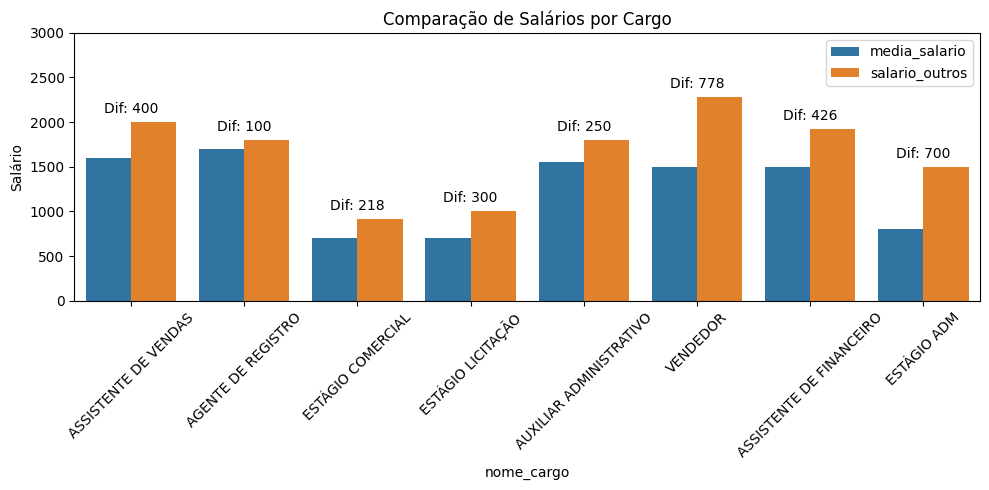

In [15]:
df_outras_empresas: pd.DataFrame = pd.DataFrame(list(cargo_diferenca_salario.items()), columns=['nome_cargo', 'salario_outros'])

df_comparacao_salarios: pd.DataFrame = pd.merge(df_mean_per_salary, df_outras_empresas, on='nome_cargo')

plt.figure(figsize=(10, 5))

df_melt = pd.melt(df_comparacao_salarios, id_vars="nome_cargo", value_vars=["media_salario", "salario_outros"], 
                  var_name="Fonte", value_name="Salário")

# Plotando o gráfico de barras com os salários comparativos
sns.barplot(x='nome_cargo', y='Salário', hue='Fonte', data=df_melt)

df_comparacao_salarios['discrepancia'] = df_comparacao_salarios['salario_outros'] - df_comparacao_salarios['media_salario']

# Adicionando a linha de discrepância
for i, discrepancia in enumerate(df_comparacao_salarios['discrepancia']):
    plt.text(i, df_comparacao_salarios['salario_outros'][i] + 100, f'Dif: {discrepancia:.0f}', ha='center')

plt.title('Comparação de Salários por Cargo')
plt.xticks(rotation=45)
plt.ylabel("Salário")
plt.legend()

plt.ylim(0, 3000)

# Ajustar layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

In [19]:
def mean_days_processing() -> pd.DataFrame:
    df: pd.DataFrame = pd.read_sql(SQL_MEAN_DAYS_PROCESSING, connection_database())
    return df

df_mean_days_processing: pd.DataFrame = mean_days_processing()
df_mean_days_processing["diferenca_dias"].round()

Conexão bem-sucedida!


0    6.0
Name: diferenca_dias, dtype: float64

In [ ]:
def media_tempo_por_vaga() -> pd.DataFrame:
    df: pd.DataFrame = pd.read_sql(SQL_MEDIA_TEMPO_POR_VAGA, connection_database())
    return df

df_media_tempo_por_vaga: pd.DataFrame = media_tempo_por_vaga()
df_media_tempo_por_vaga

In [21]:
df_media_tempo_por_vaga["diferenca_dias"] = df_media_tempo_por_vaga["diferenca_dias"].clip(lower=3)

In [28]:
media_dias = df_media_tempo_por_vaga["diferenca_dias"].mean().round()

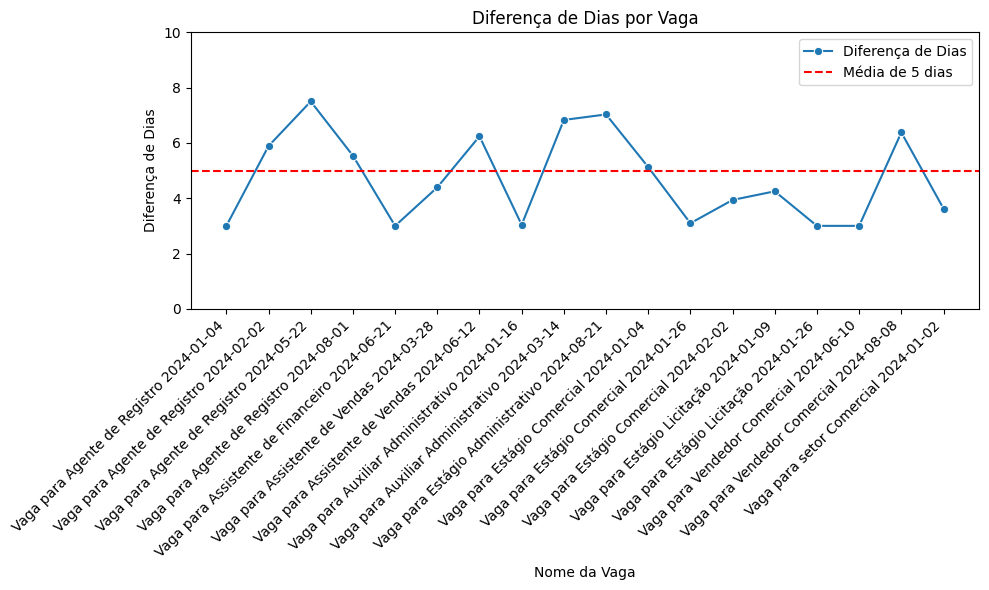

In [29]:
df_media_tempo_por_vaga = df_media_tempo_por_vaga.sort_values(by="nome_vaga")

# Criar a figura e o eixo
plt.figure(figsize=(10, 6))

# Plotar gráfico de linha usando Seaborn
sns.lineplot(x="nome_vaga", y="diferenca_dias", data=df_media_tempo_por_vaga, marker='o', label='Diferença de Dias')

plt.axhline(y=int(media_dias), color='red', linestyle='--', label='Média de 5 dias')

# Ajustar rótulos para o eixo X para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Adicionar título e rótulos dos eixos
plt.title('Diferença de Dias por Vaga')
plt.xlabel('Nome da Vaga')
plt.ylabel('Diferença de Dias')

# Exibir a legenda
plt.legend()

plt.ylim(0, 10)

# Exibir o gráfico
plt.tight_layout()
plt.show()

In [34]:
def distribuicao_candidatos_por_cargo() -> pd.DataFrame:
    df: pd.DataFrame = pd.read_sql(SQL_DISTRIBUICAO_CANDIDATOS_POR_CARGO, connection_database())
    return df

df_distribuicao_candidatos_por_cargo: pd.DataFrame = distribuicao_candidatos_por_cargo()
df_distribuicao_candidatos_por_cargo

Conexão bem-sucedida!


,nome_cargo,quantida_por_cargo
0,ASSISTENTE DE VENDAS,61
1,AGENTE DE REGISTRO,102
2,ESTÁGIO COMERCIAL,45
3,ESTÁGIO LICITAÇÃO,18
4,AUXILIAR ADMINISTRATIVO,157
5,VENDEDOR,44
6,ASSISTENTE DE FINANCEIRO,5
7,ESTÁGIO ADM,35


C:\Users\dark860\AppData\Local\Temp\ipykernel_2176\4219661137.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="quantida_por_cargo", y="nome_cargo", data=df_distribuicao_candidatos_por_cargo, palette="Blues_d")


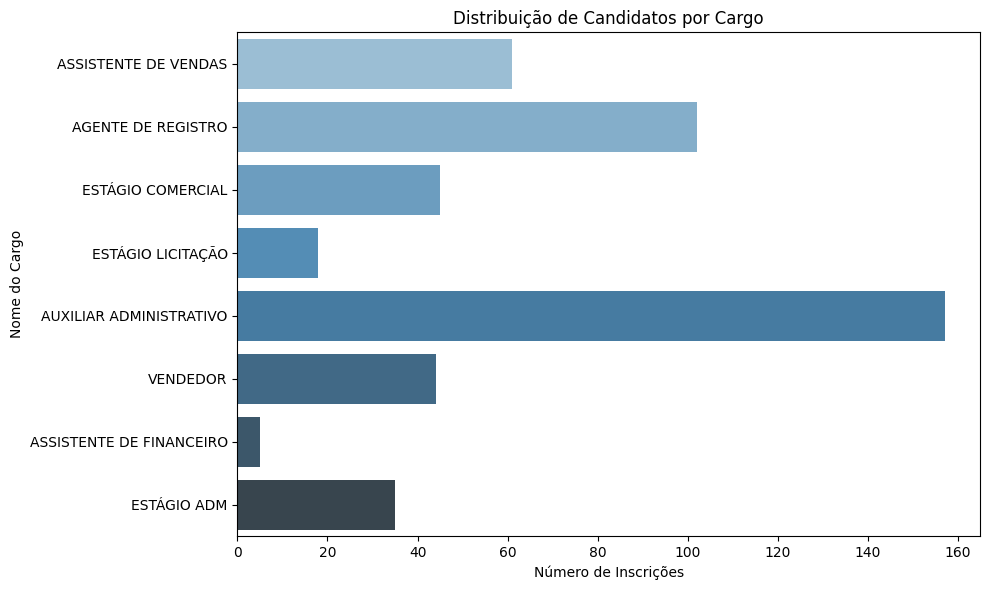

In [35]:
plt.figure(figsize=(10, 6))

# Criar gráfico de barras laterais usando Seaborn
sns.barplot(x="quantida_por_cargo", y="nome_cargo", data=df_distribuicao_candidatos_por_cargo, palette="Blues_d")

# Adicionar título e rótulos dos eixos
plt.title('Distribuição de Candidatos por Cargo')
plt.xlabel('Número de Inscrições')
plt.ylabel('Nome do Cargo')

# Ajustar o layout para não cortar partes do gráfico
plt.tight_layout()

# Exibir o gráfico
plt.show()